<a href="https://colab.research.google.com/github/Bogdan-Strat/NLP-with-disaster-tweets/blob/main/NLP_with_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install num2words
! pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from num2words import num2words
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import emoji
import string
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      </?3                       # heart
    )"""

In [ ]:
from sqlalchemy.sql.expression import null
# Preprocessing function
def lower_text(tweet):
    return tweet.lower()

def convert_number_to_words(tweet):
  tweet_num2words = []
  data = tweet.split()

  for text in data:
    if ',' in text:
            parts = text.split(',')
            converted_parts = []
            for part in parts:
                if part.isdigit():
                    number_without_comma = int(part)
                    converted_parts.append(num2words(number_without_comma))
                else:
                    converted_parts.append(part)
            converted_word = ' '.join(converted_parts)
            tweet_num2words.append(converted_word)
    elif text.isdigit():
      tweet_num2words.append(num2words(text))
    else:
      tweet_num2words.append(text)
  return ' '.join(tweet_num2words)

def remove_links(tweet):
  return ' '.join([re.sub(r'http\S+', '', word) for word in tweet.split(" ")])
 
def remove_emoticons_and_emojis(tweet):
  emoticon_re = re.compile(emoticon_string, re.VERBOSE | re.I | re.UNICODE)
  tweet = ' '.join([re.sub(emoticon_re, '', word) for word in tweet.split(" ")])
  return emoji.replace_emoji(tweet, replace='')
 
def remove_hashtags_and_mentions(tweet):
  tweets_no_hashtags = [re.sub(r'#[a-zA-Z0-9_]+','', word) for word in tweet]
  return ' '.join([re.sub(r'@[a-zA-Z0-9_]+','', word) for word in tweets_no_hashtags])
 
def remove_multiple_spaces(tweet):
  return  ' '.join([re.sub(r'\s+', ' ', word).strip() for word in tweet.split(" ")])
 
'''
Aveti grija la cazurile de tipul "unu,doi". Daca eliminati punctuatia direct, cele doua cuvinte vor 
fi concatenate obtinand un singur cuvant "unudoi". O alternativa ar fi sa inlocuim 
mai intai toate caracterele de punctuatie cu spatiu, apoi sa aplicam inca o data metoda de contractie a spatiilor.
'''
 
def remove_punctuation(tweet):
  tweets_no_punct = [re.sub(r'[^\w\s]', ' ', word) for word in tweet.split(" ")]
  return ' '.join([re.sub(r'\s+', ' ', tweet) for tweet in tweets_no_punct])

def preprocess(tweet):
  #cele mai frecvente ngrame pe cuvinte
  # concat = ""
  tweet_text = lower_text(tweet)
  tweet_text = convert_number_to_words(tweet_text)
  tweet_text = remove_links(tweet_text)
  tweet_text = remove_emoticons_and_emojis(tweet_text)
  tweet_text = remove_multiple_spaces(tweet_text)
  tweet_text = remove_punctuation(tweet_text)

  # if str(tweet[1]) == 'nan':
  #   concat = ""
  # else:
  #   concat += str(tweet[1]) + "[SEP] "
  
  # if str(tweet[2]) == 'nan':
  #   concat += ""
  # else:
  #   concat += str(tweet[2]) + "[SEP] "
 
  # tweet_text = concat + tweet_text
  return tweet_text

In [ ]:
def remove_stopwords(tweet):
  stop_words_nltk = set(stopwords.words('english'))
  all_words = [word for word in tweet]
  all_words_without_stops = [word for word in all_words if word not in stop_words_nltk]
  return all_words_without_stops

def lematizer(tweet):
  words_lemmatize = []
  stemmer = SnowballStemmer(language='english')
  for token in tweet:
    words_lemmatize.append(stemmer.stem(token))
  return words_lemmatize

def tokenizer(tweet):
  tweet = word_tokenize(tweet)
  tweet = remove_stopwords(tweet)
  tweet = lematizer(tweet)
  return tweet

In [ ]:
data = pd.read_csv("train.csv")  
data

test = pd.read_csv('test.csv')
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [ ]:
# X = data['text']
# # for i in range(len(data['text'])):
# #   X.append((data['text'][i], data['keyword'][i], data['location'][i]))

# y = data['target']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = data['text']
# for i in range(len(data['text'])):
#   X_train.append((data['text'][i], data['keyword'][i], data['location'][i]))

y_train = data['target']


X_test = test['text']
# for i in range(len(test['text'])):
#   X_test.append((test['text'][i], test['keyword'][i], test['location'][i]))
test_ids = test['id']

# Vectorize the email bodies with lowercase preprocessing
vectorizer = TfidfVectorizer(preprocessor=preprocess, tokenizer=tokenizer, analyzer='word', ngram_range=(1, 10))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001, 0.0001],'kernel': ['rbf', 'linear']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train_vectorized,y_train)

print(grid.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.580 total time=  10.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.582 total time=   8.6s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.592 total time=   9.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.576 total time=   9.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.584 total time=   8.5s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.589 total time=   8.6s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.595 total time=   8.7s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.602 total time=   9.2s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.589 total time=   8.6s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.599 total time=   8.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.569 total time=   8.7s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

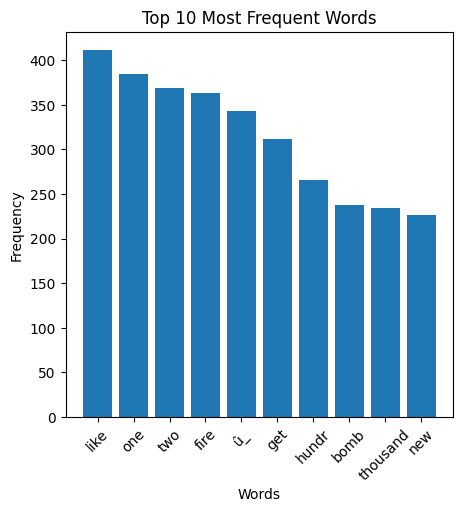

In [ ]:
def plot_most_frequent_words(text, num_words=10):
    # Preprocess the text
    #words = re.findall(r'\w+', text)
 
    # Count the frequency of each word
    word_counts = Counter(text)
 
    # Sort the words by frequency
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
 
    # Select the top N most frequent words
    top_words = sorted_words[:num_words]
    word_labels = [word for word, count in top_words]
    word_frequencies = [count for word, count in top_words]
 
    # Plot the data
    plt.figure(figsize=(5, 5))
    plt.bar(word_labels, word_frequencies)
    plt.title(f'Top {num_words} Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()
 
full_text = []
for line in X_train:
  line = preprocess(line)
  line = tokenizer(line)
  full_text.extend(line)
plot_most_frequent_words(full_text)

Accuracy: 0.7846355876559422
Precision: 0.8451612903225807
Recall: 0.6055469953775039
F1: 0.7055655296229802
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       874
           1       0.85      0.61      0.71       649

    accuracy                           0.78      1523
   macro avg       0.80      0.76      0.77      1523
weighted avg       0.80      0.78      0.78      1523

[[802  72]
 [256 393]]


<Axes: >

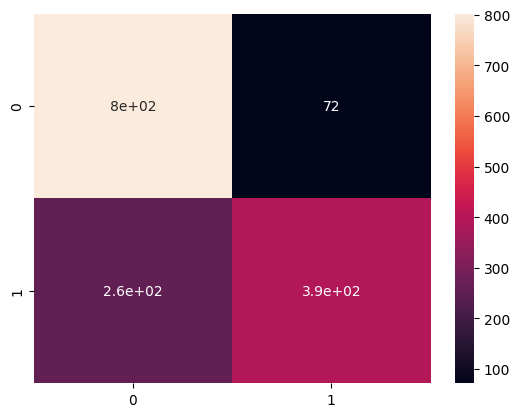

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

# Predict on the test set
predictions = nb_classifier.predict(X_test_vectorized)

# solutions = []
# for i in range(len(predictions)):
#   solutions.append([test_ids[i], predictions[i]])
# solutions

# file = open('solutions.csv', 'w')
# file.write('id,target\n')

# for solution in solutions:
#   file.write(str(solution[0]))
#   file.write(',')
#   file.write(str(solution[1]))
#   file.write('\n')
# file.close()

# Evaluate the classifier
accuracy = (predictions == y_test).mean()
print(f"Accuracy: {accuracy}")
print("Precision:", metrics.precision_score(y_test, predictions))
print("Recall:", metrics.recall_score(y_test, predictions))
print("F1:", metrics.f1_score(y_test, predictions))
print(metrics.classification_report(y_test, predictions))
 
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
svm_classifier = SVC(C=100, gamma=0.01, kernel='linear')
svm_classifier.fit(X_train_vectorized, y_train)

# Predict on the test set
predictions = svm_classifier.predict(X_test_vectorized)

solutions = []
for i in range(len(predictions)):
  solutions.append([test_ids[i], predictions[i]])
solutions

file = open('solutions.csv', 'w')
file.write('id,target\n')

for solution in solutions:
  file.write(str(solution[0]))
  file.write(',')
  file.write(str(solution[1]))
  file.write('\n')

file.close()

# Evaluate the classifier
# accuracy = (predictions == y_test).mean()
# print(f"Accuracy: {accuracy}")
# print("Precision:", metrics.precision_score(y_test, predictions))
# print("Recall:", metrics.recall_score(y_test, predictions))
# print("F1:", metrics.f1_score(y_test, predictions))
# print(metrics.classification_report(y_test, predictions))
 
# cm = metrics.confusion_matrix(y_test, predictions)
# print(cm)
# sns.heatmap(cm, annot=True)

In [ ]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_vectorized, y_train)

# Predict on the test set
predictions = knn_classifier.predict(X_test_vectorized)

# Evaluate the classifier
accuracy = (predictions == y_test).mean()
print(f"Accuracy: {accuracy}")
# print("Precision:", metrics.precision_score(y_test, predictions))
# print("Recall:", metrics.recall_score(y_test, predictions))
# print("F1:", metrics.f1_score(y_test, predictions))
# print(metrics.classification_report(y_test, predictions))
 
# cm = metrics.confusion_matrix(y_test, predictions)
# print(cm)
# sns.heatmap(cm, annot=True)

Accuracy: 0.7570584372948129


In [ ]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_vectorized, y_train)

# Predict on the test set
predictions = dt_classifier.predict(X_test_vectorized)

# Evaluate the classifier
accuracy = (predictions == y_test).mean()
print(f"Accuracy: {accuracy}")
# print("Precision:", metrics.precision_score(y_test, predictions))
# print("Recall:", metrics.recall_score(y_test, predictions))
# print("F1:", metrics.f1_score(y_test, predictions))
# print(metrics.classification_report(y_test, predictions))
 
# cm = metrics.confusion_matrix(y_test, predictions)
# print(cm)
# sns.heatmap(cm, annot=True)

Accuracy: 0.7150361129349967


In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_vectorized, y_train)

# Predict on the test set
predictions = rf_classifier.predict(X_test_vectorized)

solutions = []
for i in range(len(predictions)):
  solutions.append([test_ids[i], predictions[i]])
solutions

file = open('solutions.csv', 'w')
file.write('id,target\n')

for solution in solutions:
  file.write(str(solution[0]))
  file.write(',')
  file.write(str(solution[1]))
  file.write('\n')

file.close()

# Evaluate the classifier
# accuracy = (predictions == y_test).mean()
# print(f"Accuracy: {accuracy}")
# print("Precision:", metrics.precision_score(y_test, predictions))
# print("Recall:", metrics.recall_score(y_test, predictions))
# print("F1:", metrics.f1_score(y_test, predictions))
# print(metrics.classification_report(y_test, predictions))
 
# cm = metrics.confusion_matrix(y_test, predictions)
# print(cm)
# sns.heatmap(cm, annot=True)